Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

Data Load

In [ ]:
data = pd.read_csv("customer_segmentation.csv", encoding='ISO-8859-1' )

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Preprocessing

In [ ]:
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

In [ ]:
data.dropna(subset=['CustomerID'], inplace=True)

Outlier Handling

In [ ]:
for col in ['Quantity', 'TotalAmount']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound,
                         np.where(data[col] > upper_bound, upper_bound, data[col]))

Feature Engineering

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

In [ ]:
if data['InvoiceDate'].isnull().sum() > 0:
    print("Warning: Some InvoiceDate values could not be parsed. They will be dropped.")
    data = data.dropna(subset=['InvoiceDate'])
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

In [ ]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

In [ ]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
rfm['ChannelPreference'] = np.random.choice(['Online', 'Offline'], size=len(rfm))

In [ ]:
rfm = pd.get_dummies(rfm, columns=['ChannelPreference'], drop_first=True)

Splitting the data

In [ ]:
X = rfm.drop(['CustomerID', 'Monetary'], axis=1)
y = rfm['Monetary']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ensemble Models: Bagging, Boosting, and Stacking

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
estimators = [('rf', rf_model), ('gb', gb_model), ('xgb', xgb_model)]

In [ ]:
stack_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=42))
stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_type...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=RandomForestRegressor(random_state=42))

Model Evaluation

In [ ]:
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'XGBoost': xgb_model, 'Stacking': stack_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MSE = {mse:.2f}, R2 = {r2:.2f}")

Random Forest: MSE = 7946747.72, R2 = 0.19
Gradient Boosting: MSE = 15016718.66, R2 = -0.52
XGBoost: MSE = 9401050.23, R2 = 0.05
Stacking: MSE = 7775503.17, R2 = 0.21


Feature Importance

In [ ]:
importances = rf_model.feature_importances_

In [ ]:
features = X.columns

In [ ]:
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

In [ ]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
def plot_feature_importance(model, model_name, features):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importance ({model_name})')
        plt.show()
    else:
        print(f"{model_name} does not support feature importance visualization.")

In [ ]:
models_with_importance = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,

}

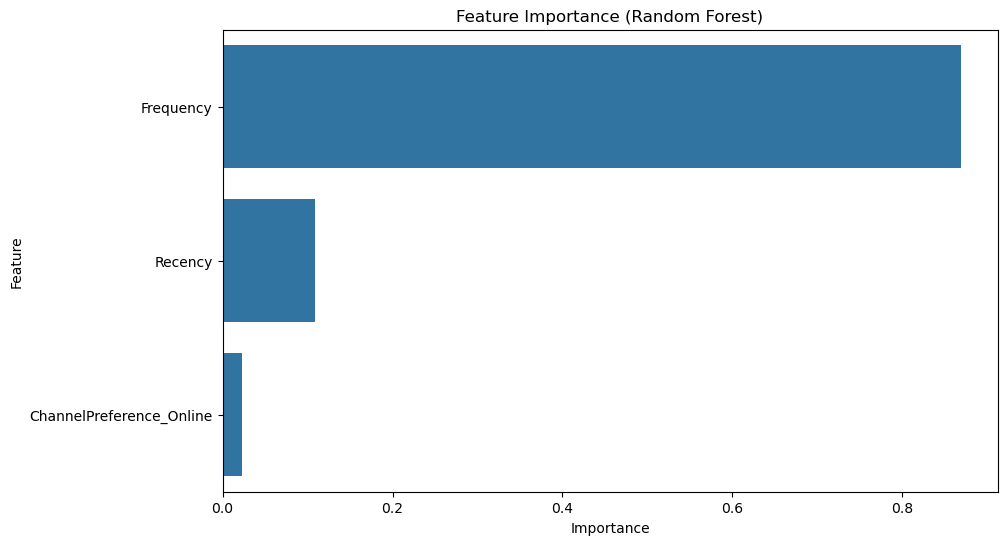

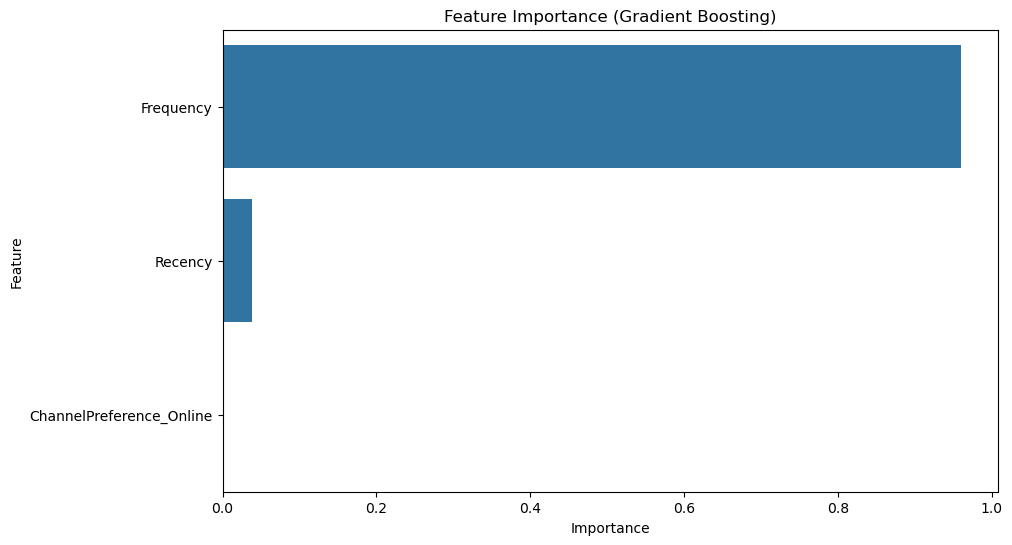

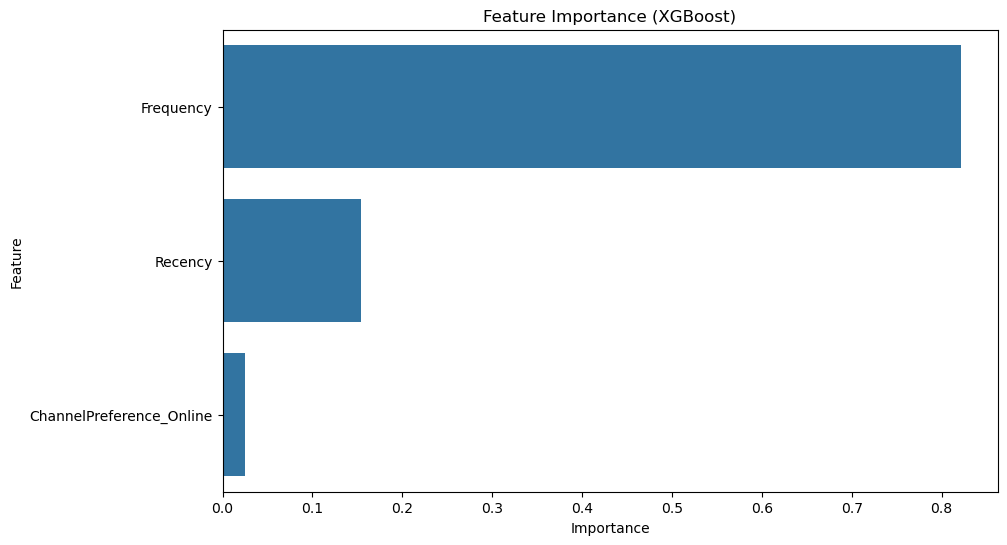

In [ ]:
for model_name, model in models_with_importance.items():
    plot_feature_importance(model, model_name, X.columns)